#### Loading data sources

In [2]:
#pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
# This Jupyter Notebook does feature engineering joining all features in all tables.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,roc_curve,roc_auc_score

#### Parameters

In [2]:
# We start analysis for the below period where attendance system is properly implemented at the given organization.
analysis_period_start_time = pd.to_datetime('2020-02-01 00:00:00')
analysis_period_end_time = pd.to_datetime('2022-12-31 23:59:59')

#### Load the dataset

In [3]:
# Read employees dataset
# df_employee_raw = pd.read_csv('data/employees4.csv', na_values=['\\N'], on_bad_lines='skip', infer_datetime_format=True, parse_dates=['Date_Joined', 'Date_Resigned', 'Inactive_Date'])
df_employee_raw = pd.read_csv('C://Users//amalipe//OneDrive - John Keells Holdings PLC//MSc//Semester 01//CS5803 - Data mining//project//attrition//data//employees4.csv', na_values=['\\N'], on_bad_lines='skip', infer_datetime_format=True, parse_dates=['Date_Joined', 'Date_Resigned', 'Inactive_Date'])
df_leaves = pd.read_csv('C://Users//amalipe//OneDrive - John Keells Holdings PLC//MSc//Semester 01//CS5803 - Data mining//project//attrition//data//leaves_clean.csv')

##### Preprocess df_employee table

In [4]:
# Clean employee table
# Drop Employee_Code because it's not referenced in other tables.
# Other fields are dropped
df_employee = df_employee_raw.drop(['Employee_Code', 'Name', 'Address_Line_1', 'Address_Line_2', 'Address_Line_3',
                                    'Reporting_emp_1', 'Reporting_emp_2', 'Title', 'Religion', 'Religion_ID', 'Designation_ID'], axis=1)

date_range = (df_employee['Date_Joined'] >= analysis_period_start_time) & (df_employee['Date_Joined'] <= analysis_period_end_time)
df_employee = df_employee.loc[date_range]
df_employee.head(4)

,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation
58,426,1962-05-10,Male,Married,2020-07-03,2021-10-26,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist
73,450,1976-05-27,Male,Married,2020-12-03,2021-04-09,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor
78,457,1967-03-20,Male,Married,2020-06-01,NaN,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor
79,460,1955-03-10,Male,Married,2020-03-01,0000-00-00,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor


In [5]:
df_employee_raw.info()

print(f'Total employees {str(df_employee_raw["Employee_Code"].nunique())}')
print(f'Earliest join date {str(df_employee_raw["Date_Joined"].min())}')
print(f'Latest join date {str(df_employee_raw["Date_Joined"].max())}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee_No          1261 non-null   int64         
 1   Employee_Code        1261 non-null   int64         
 2   Name                 1261 non-null   object        
 3   Title                1261 non-null   object        
 4   Address_Line_1       1261 non-null   object        
 5   Address_Line_2       1181 non-null   object        
 6   Address_Line_3       952 non-null    object        
 7   Date_of_Birth        1261 non-null   object        
 8   Gender               1261 non-null   object        
 9   Religion_ID          1261 non-null   int64         
 10  Marital_Status       1170 non-null   object        
 11  Designation_ID       1261 non-null   int64         
 12  Date_Joined          1261 non-null   datetime64[ns]
 13  Date_Resigned        955 non-null

##### Preprocess df_leaves table

In [6]:
df_leaves = df_leaves.rename(columns={'leave_date': 'Leave_Date',
                                      'Type': 'Leave_Factor',
                                      'Applied Date': 'Applied_Date',
                                      'leave_leave_date': 'Lieu_Leave_Date',
                                      'Remarks': 'Remarks',
                                      'apply_type': 'Leave_Category'})
df_leaves_type_map = {'Half Day': 0.5, 'Full Day': 1}
df_leaves['Leave_Factor'] = df_leaves['Leave_Factor'].map(df_leaves_type_map)
df_leaves_legit = pd.DataFrame(df_leaves.loc[(df_leaves['Leave_Category'] != 'Liue Leave') & (df_leaves['Leave_Category'] != 'Curfew') & (df_leaves['Leave_Category'] != 'Sat Holiday')])
df_leaves_summary_temp = df_leaves.groupby('Employee_No')['Leave_Factor'].sum()
df_leaves_summary = pd.DataFrame({'Employee_No': df_leaves_summary_temp.index, 'Leave_Count':  df_leaves_summary_temp.values})
df_leaves_summary.head()

,Employee_No,Leave_Count
0,347,52.5
1,348,21.5
2,351,57.0
3,352,105.5
4,354,79.5


#### Data processing

In [7]:
df_employee['Date_Joined'].describe()

C:\Users\amalipe\AppData\Local\Temp/ipykernel_9648/2458401512.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_employee['Date_Joined'].describe()


count                     796
unique                    369
top       2021-02-01 00:00:00
freq                       23
first     2020-02-01 00:00:00
last      2022-12-20 00:00:00
Name: Date_Joined, dtype: object

##### Combining datasets

In [8]:
# Group two datasets

df_employee = pd.merge(df_employee, df_leaves_summary, on='Employee_No', how='left')
df_employee['Leave_Count'].fillna(0, inplace=True)
df_employee.head()

,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation,Leave_Count
0,426,1962-05-10,Male,Married,2020-07-03,2021-10-26,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist,11.0
1,450,1976-05-27,Male,Married,2020-12-03,2021-04-09,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor,60.0
2,457,1967-03-20,Male,Married,2020-06-01,NaN,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor,0.0
3,460,1955-03-10,Male,Married,2020-03-01,0000-00-00,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor,0.0
4,471,1992-08-16,Male,Single,2021-04-01,2022-02-28,Inactive,RESIGN,2022-02-28,Labour,Contarct Basis,Skilled Labor,73.5


#### Data Preprocessing

##### Missing values

In [9]:
df_employee.isna().sum()/len(df_employee)

Employee_No            0.000000
Date_of_Birth          0.000000
Gender                 0.000000
Marital_Status         0.096734
Date_Joined            0.000000
Date_Resigned          0.175879
Status                 0.000000
Status_Reason          0.192211
Inactive_Date          0.104271
Employment_Category    0.000000
Employment_Type        0.000000
Designation            0.000000
Leave_Count            0.000000
dtype: float64

In [10]:
df_employee["Marital_Status"].mode()

0    Married
dtype: object

In [11]:
df_employee["Marital_Status"] = df_employee["Marital_Status"].fillna("Married")

In [12]:
df_employee.isna().sum()/len(df_employee)

Employee_No            0.000000
Date_of_Birth          0.000000
Gender                 0.000000
Marital_Status         0.000000
Date_Joined            0.000000
Date_Resigned          0.175879
Status                 0.000000
Status_Reason          0.192211
Inactive_Date          0.104271
Employment_Category    0.000000
Employment_Type        0.000000
Designation            0.000000
Leave_Count            0.000000
dtype: float64

##### Duplicated values

In [13]:
duplicateRows = df_employee[df_employee.duplicated()]
duplicateRows.shape   ### No duplicates

(0, 13)

##### Outliers

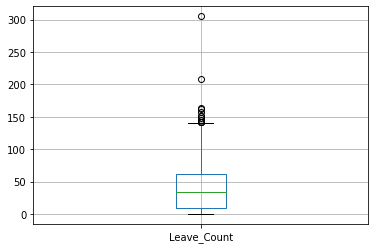

In [18]:
boxplot = df_employee.boxplot(column=["Leave_Count"]) 

#### Descriptive Analysis

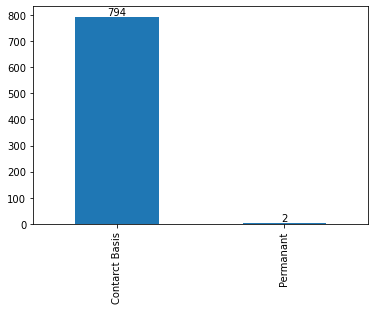

In [9]:
temp_plot = df_employee['Employment_Type'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Employment_Type'].value_counts())
plt.show()

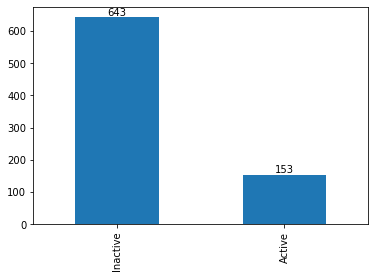

In [10]:
temp_plot = df_employee['Status'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Status'].value_counts())
plt.show()

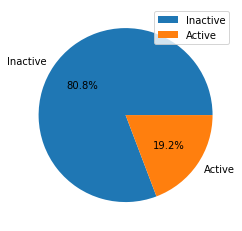

In [11]:
plt.pie(df_employee['Status'].value_counts(), labels=df_employee['Status'].unique(), autopct='%1.1f%%')
plt.legend()
plt.show()

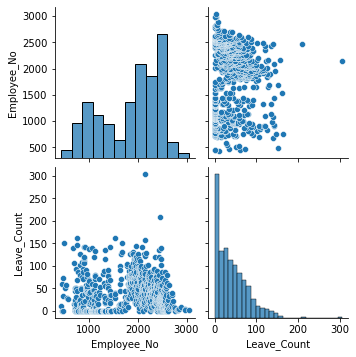

In [12]:
seaborn.pairplot(df_employee)

In [13]:
df_employee_inactive_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_inactive_contract_based['Date_Joined'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Joined'])
df_employee_inactive_contract_based['Date_Resigned'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Resigned'], errors='coerce')
df_employee_inactive_contract_based['Employment_Duration'] = df_employee_inactive_contract_based['Date_Resigned'].fillna(df_employee_inactive_contract_based['Inactive_Date']) - df_employee_inactive_contract_based['Date_Joined'] + pd.Timedelta(days=1)
df_employee_inactive_contract_based = df_employee_inactive_contract_based.drop(df_employee_inactive_contract_based[df_employee_inactive_contract_based['Employment_Duration'] < pd.Timedelta(days=0)].index)
df_employee_inactive_contract_based['Unavailability_Factor'] = df_employee_inactive_contract_based['Leave_Count'] / df_employee_inactive_contract_based['Employment_Duration'].dt.days

# Annotating attrition or not. If the resignation date is a multiple of 1 year contract, we don't consider that as attrition.
df_employee_inactive_contract_based.loc[df_employee_inactive_contract_based['Employment_Duration'].dt.days % 365 == 0, 'Is_Attrition'] = 0
df_employee_inactive_contract_based.loc[df_employee_inactive_contract_based['Employment_Duration'].dt.days % 365 != 0, 'Is_Attrition'] = 1
df_employee_inactive_contract_based['Employment_Duration'].describe()

count                            641
mean     205 days 04:36:19.095163806
std      184 days 18:07:16.742888928
min                  1 days 00:00:00
25%                 68 days 00:00:00
50%                158 days 00:00:00
75%                291 days 00:00:00
max                933 days 00:00:00
Name: Employment_Duration, dtype: object

In [1253]:
# Too little permanent employees.

# df_employee_inactive = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive')])
# df_employee_inactive['Date_Joined'] = pd.to_datetime(df_employee_inactive['Date_Joined'])
# df_employee_inactive['Date_Resigned'] = pd.to_datetime(df_employee_inactive['Date_Resigned'], errors='coerce')
# df_employee_inactive['Employment_Duration'] = df_employee_inactive['Date_Resigned'] - df_employee_inactive['Date_Joined'] + pd.Timedelta(days=1)
# df_employee_inactive['Unavailability_Factor'] = df_employee_inactive['Leave_Count'] / df_employee_inactive['Employment_Duration'].dt.days
# df_employee_inactive['Employment_Duration'].describe()

In [14]:
# Active contract base employee analysis.

df_employee_active_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Active') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_active_contract_based['Date_Joined'] = pd.to_datetime(df_employee_active_contract_based['Date_Joined'])
df_employee_active_contract_based['Employment_Duration'] = analysis_period_end_time - df_employee_active_contract_based['Date_Joined'] + pd.Timedelta(days=1)
df_employee_active_contract_based['Unavailability_Factor'] = df_employee_active_contract_based['Leave_Count'] / df_employee_active_contract_based['Employment_Duration'].dt.days
# Annotating active employees as non-attrition.
df_employee_active_contract_based['Is_Attrition'] = 0
df_employee_active_contract_based['Employment_Duration'].describe()

count                            152
mean     458 days 21:09:27.421052632
std      258 days 03:59:08.662802828
min                 12 days 23:59:59
25%                296 days 17:59:59
50%                368 days 11:59:59
75%                537 days 11:59:59
max               1065 days 23:59:59
Name: Employment_Duration, dtype: object

In [15]:
df_employee_inactive_contract_based['Leave_Count'].describe()

count    641.000000
mean      38.219969
std       33.486809
min        0.000000
25%       10.000000
50%       32.000000
75%       58.500000
max      163.000000
Name: Leave_Count, dtype: float64

In [16]:
df_employee_active_contract_based['Leave_Count'].describe()

count    152.000000
mean      55.019737
std       50.304565
min        0.000000
25%       12.500000
50%       49.250000
75%       82.375000
max      305.000000
Name: Leave_Count, dtype: float64

In [17]:
df_employee_inactive_contract_based['Unavailability_Factor'].describe()

count    641.000000
mean       0.512923
std        1.840379
min        0.000000
25%        0.059783
50%        0.215827
75%        0.363222
max       20.000000
Name: Unavailability_Factor, dtype: float64

In [18]:
df_employee_active_contract_based['Unavailability_Factor'].describe()

count    152.000000
mean       0.127464
std        0.112425
min        0.000000
25%        0.045296
50%        0.108324
75%        0.190642
max        0.626283
Name: Unavailability_Factor, dtype: float64

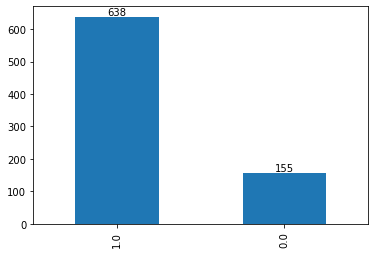

In [19]:
# Joining tables for attrition.
df_employee_for_modeling = pd.concat([df_employee_inactive_contract_based, df_employee_active_contract_based])
df_employee_for_modeling['Employment_Duration'] = df_employee_for_modeling['Employment_Duration'].dt.days
temp_plot = df_employee_for_modeling['Is_Attrition'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Is_Attrition'].value_counts())
plt.show()

#### Creating Dummy Variables

In [21]:
df_employee_for_modeling.head()

,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation,Leave_Count,Employment_Duration,Unavailability_Factor,Is_Attrition
0,426,1962-05-10,Male,Married,2020-07-03,2021-10-26 00:00:00,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist,11.0,481,0.022869,1.0
1,450,1976-05-27,Male,Married,2020-12-03,2021-04-09 00:00:00,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor,60.0,128,0.468750,1.0
2,457,1967-03-20,Male,Married,2020-06-01,NaT,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor,0.0,117,0.000000,1.0
3,460,1955-03-10,Male,Married,2020-03-01,NaT,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor,0.0,31,0.000000,1.0
4,471,1992-08-16,Male,Single,2021-04-01,2022-02-28 00:00:00,Inactive,RESIGN,2022-02-28,Labour,Contarct Basis,Skilled Labor,73.5,334,0.220060,1.0


##### Checking categories in each variable

In [22]:
df_employee_for_modeling['Gender'].value_counts()  # need to create dummy variables

Male      735
Female     58
Name: Gender, dtype: int64

In [65]:
df_employee_for_modeling['Marital_Status'].value_counts()  # need to create dummy variables

Married    470
Single     247
Name: Marital_Status, dtype: int64

In [24]:
df_employee_for_modeling['Status'].value_counts()  # need to create dummy variables

Inactive    641
Active      152
Name: Status, dtype: int64

In [25]:
df_employee_for_modeling['Status_Reason'].value_counts()  ## cant have dummy variables - too many categories

RESIGN                                                          442
Resign                                                          114
Resigned                                                         22
resign                                                           18
VOP                                                              14
resigned                                                          9
Left                                                              5
Discontinuation of Service on Fixed Term Employment Contract      2
Bulk Termination                                                  2
RESIGNED                                                          2
 resign                                                           2
SERVICE DISCONTINUATION                                           2
vOP                                                               1
Bulk Terminaion                                                   1
Resigend                                        

In [26]:
df_employee_for_modeling['Employment_Category'].value_counts()

Labour        532
Staff         241
Management     20
Name: Employment_Category, dtype: int64

In [27]:
df_employee_for_modeling['Employment_Type'].value_counts()

Contarct Basis    793
Name: Employment_Type, dtype: int64

In [28]:
df_employee_for_modeling['Designation'].value_counts() ## need to remove - too many categories

Unskilled Labor               317
Mason                          33
Skilled Labor                  28
Technical Officer              26
Semi Skilled Labor             24
                             ... 
IT Consultant                   1
Data Entry Executive            1
Planning Engineer cum QAQC      1
Trainee Safety Officer          1
Software Developer              1
Name: Designation, Length: 107, dtype: int64

##### Creating dummy variables

In [29]:
df_dummy = pd.get_dummies(df_employee_for_modeling[["Gender","Marital_Status", "Status", "Employment_Category"]])
df_dummy.head()

,Gender_Female,Gender_Male,Marital_Status_Married,Marital_Status_Single,Status_Active,Status_Inactive,Employment_Category_Labour,Employment_Category_Management,Employment_Category_Staff
0,0,1,1,0,0,1,0,0,1
1,0,1,1,0,0,1,1,0,0
2,0,1,1,0,0,1,1,0,0
3,0,1,1,0,0,1,1,0,0
4,0,1,0,1,0,1,1,0,0


In [30]:
## Removing one level from each

df_dummy.drop(["Gender_Female","Marital_Status_Single","Status_Active","Employment_Category_Management"],axis=1,inplace=True)

In [31]:
df_employee_final = pd.concat([df_dummy, df_employee_for_modeling],axis=1)
df_employee_final.head()

,Gender_Male,Marital_Status_Married,Status_Inactive,Employment_Category_Labour,Employment_Category_Staff,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,...,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation,Leave_Count,Employment_Duration,Unavailability_Factor,Is_Attrition
0,1,1,1,0,1,426,1962-05-10,Male,Married,2020-07-03,...,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist,11.0,481,0.022869,1.0
1,1,1,1,1,0,450,1976-05-27,Male,Married,2020-12-03,...,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor,60.0,128,0.468750,1.0
2,1,1,1,1,0,457,1967-03-20,Male,Married,2020-06-01,...,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor,0.0,117,0.000000,1.0
3,1,1,1,1,0,460,1955-03-10,Male,Married,2020-03-01,...,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor,0.0,31,0.000000,1.0
4,1,0,1,1,0,471,1992-08-16,Male,Single,2021-04-01,...,Inactive,RESIGN,2022-02-28,Labour,Contarct Basis,Skilled Labor,73.5,334,0.220060,1.0


In [32]:
df_employee_final.columns

Index(['Gender_Male', 'Marital_Status_Married', 'Status_Inactive',
       'Employment_Category_Labour', 'Employment_Category_Staff',
       'Employee_No', 'Date_of_Birth', 'Gender', 'Marital_Status',
       'Date_Joined', 'Date_Resigned', 'Status', 'Status_Reason',
       'Inactive_Date', 'Employment_Category', 'Employment_Type',
       'Designation', 'Leave_Count', 'Employment_Duration',
       'Unavailability_Factor', 'Is_Attrition'],
      dtype='object')

In [33]:
## Rmove original categorical variables

df_employee_final.drop(["Employee_No","Date_of_Birth","Gender","Marital_Status","Date_Joined","Date_Resigned","Status","Status_Reason","Inactive_Date","Employment_Category","Employment_Type","Designation","Status_Inactive"],axis=1,inplace=True)
df_employee_final.head() 

,Gender_Male,Marital_Status_Married,Employment_Category_Labour,Employment_Category_Staff,Leave_Count,Employment_Duration,Unavailability_Factor,Is_Attrition
0,1,1,0,1,11.0,481,0.022869,1.0
1,1,1,1,0,60.0,128,0.468750,1.0
2,1,1,1,0,0.0,117,0.000000,1.0
3,1,1,1,0,0.0,31,0.000000,1.0
4,1,0,1,0,73.5,334,0.220060,1.0


#### Checking multicolinearity of independent variables

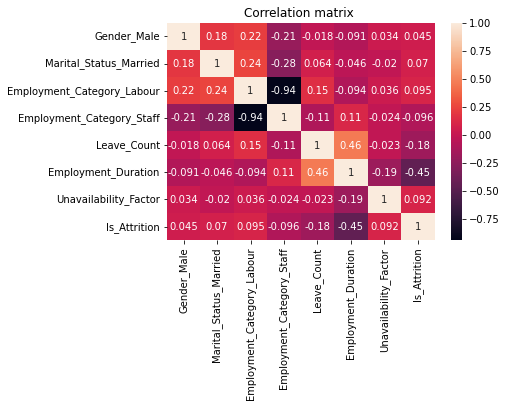

In [34]:
#creating the correlation matrix
matrix = df_employee_final.corr()
sns.heatmap(matrix, annot=True)
plt.title("Correlation matrix ")
plt.show()

In [36]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for regression model using 'rating' as response variable 
y, X = dmatrices('Is_Attrition ~ Gender_Male+Marital_Status_Married+Employment_Category_Labour+Employment_Category_Staff+Leave_Count+Employment_Duration+Unavailability_Factor', data=df_employee_final, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 

#calculate VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [37]:
vif_df

,variable,VIF
0,Intercept,55.291179
1,Gender_Male,1.074939
2,Marital_Status_Married,1.112027
3,Employment_Category_Labour,9.329894
4,Employment_Category_Staff,9.389651
5,Leave_Count,1.338289
6,Employment_Duration,1.364458
7,Unavailability_Factor,1.045126


So, need to remove Employment_Category_Labour and Employment_Category_staff before modelling

In [38]:
df_employee_final.drop(["Employment_Category_Labour","Employment_Category_Staff"],axis=1,inplace=True)
df_employee_final.head() #This data frame can be used for further processes

,Gender_Male,Marital_Status_Married,Leave_Count,Employment_Duration,Unavailability_Factor,Is_Attrition
0,1,1,11.0,481,0.022869,1.0
1,1,1,60.0,128,0.468750,1.0
2,1,1,0.0,117,0.000000,1.0
3,1,1,0.0,31,0.000000,1.0
4,1,0,73.5,334,0.220060,1.0


#### Handling data imbalance

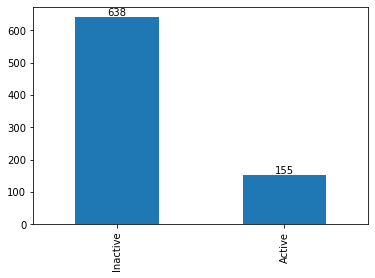

In [20]:
temp_plot = df_employee_for_modeling['Status'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Is_Attrition'].value_counts())
plt.show()

Data imbalance should be handled as the percentage of inactive employees is 80.5% and active employees is 19.5%.
This can be handled using SMOTE technique.

In [39]:
x=df_employee_final.iloc[:,:5]
y=df_employee_final.iloc[:,5]

In [40]:
smt=SMOTE(random_state = 10)
x_sm,y_sm = smt.fit_resample(x,y)
y_sm.value_counts()

1.0    638
0.0    638
Name: Is_Attrition, dtype: int64

#### Logistic Regression

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, random_state=55)
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [42]:
y_predicted = model.predict(x_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_test, y_predicted)
print(f'Precision: {precision}')
recall = recall_score(y_test, y_predicted)
print(f'Recall: {recall}')
f1 = f1_score(y_test, y_predicted)
print(f'F1 score: {f1}')
r2 = f1_score(y_test, y_predicted)
print(f'R2 score: {r2}')

Accuracy: 0.73046875
Precision: 0.7166666666666667
Recall: 0.7107438016528925
F1 score: 0.7136929460580912
R2 score: 0.7136929460580912


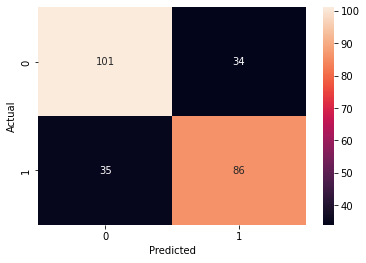

In [48]:
sns.heatmap(confusion_matrix(y_test,y_predicted),annot=True,fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
accuracy_L=(np.diag(confusion_matrix(y_test,y_predicted)).sum())/len(y_test)
accuracy_L

0.73046875

In [50]:
print("Accuracy of Logistic Regression:",accuracy_L,'\n')
print(classification_report(y_test,y_predicted))

Accuracy of Logistic Regression: 0.73046875 

              precision    recall  f1-score   support

         0.0       0.74      0.75      0.75       135
         1.0       0.72      0.71      0.71       121

    accuracy                           0.73       256
   macro avg       0.73      0.73      0.73       256
weighted avg       0.73      0.73      0.73       256

